# News Categorizers Scratch work

In [293]:
# Imports 
import string
import numpy as np
import pandas as pd

import re 

import nltk
# nltk.download('punkt')
from nltk.stem.porter import *

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset creation and Exploratory Data Analysis

In [262]:
# Read in data
data = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [263]:
# Create category dictionary linking unique categories 
category_dict = {cat: i for i, cat in enumerate(data.category.unique())}
category_dict

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

In [264]:
# Create target attribute which has the corresponding category id established above
data['target'] = data['category'].map(category_dict)
data.head()

,category,headline,authors,link,short_description,date,target
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,1
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,1
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,1
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,1


In [265]:
# Combine both the headline and the short description 
data['combined'] = data.headline + '. ' + data.short_description 

In [266]:
cat_counts = data.category.value_counts()
cat_counts

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

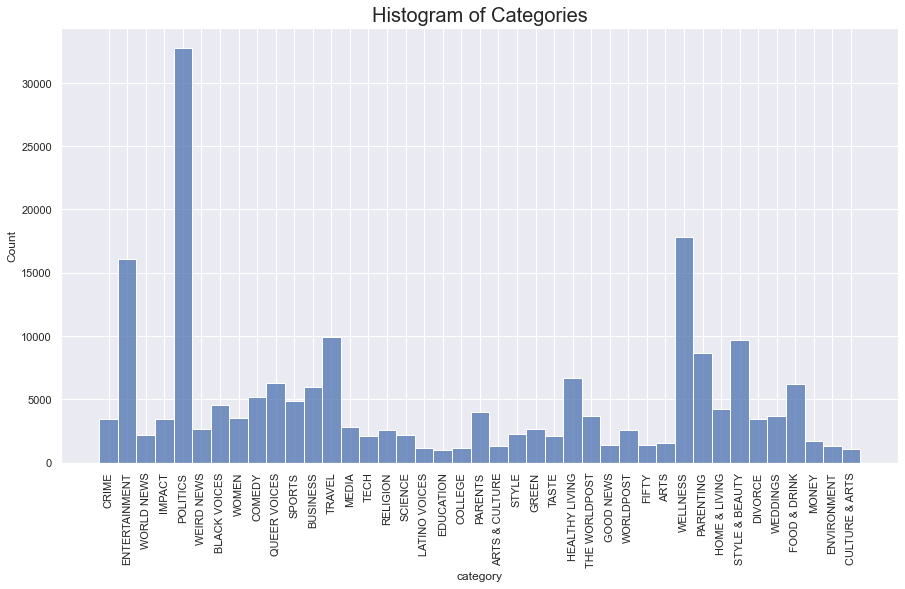

In [267]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=data, x='category')
plt.xticks(rotation=90)
plt.title('Histogram of Categories', fontsize=20)
plt.show()

Clear from this visualization is that there seem to be class imbalance among many of the categories. As one can see, the most popular category by a long-shot is politics (32739 observations), whereas other categories like "Arts" and "Environment" have far fewer; 1509 and 1323 observations, respectively. Therefore, we will likely need to adjust for class imbalance in some way to achieve better predictions. 

### First for eda, we need to clean up the text data
This process will be repeated when we fit our model, but will be encapsulated in sckikit-learn functionality.

In [268]:
eda_data = data.copy()

#### Convert combined text to lowercase

In [269]:
random_obs = np.random.randint(0, len(eda_data))

In [270]:
eda_data['cleaned'] = eda_data.combined.apply(lambda x: x.lower())

In [271]:
eda_data.cleaned[random_obs]

"cooking with coconut water. do you like coconut water? leave a comment below. touting natural health benefits similar to what you'd get with a sports"

#### Remove digits, spaces, tabs

In [272]:
eda_data['cleaned'] = eda_data.cleaned.apply(lambda x: re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', x))

# text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)

In [273]:
eda_data.cleaned[random_obs]  # extra whitespace won't matter when we split

'cooking with coconut water  do you like coconut water  leave a comment below  touting natural health benefits similar to what you d get with a sports'

#### Remove stop words
Stop words are considered  words are very common (e.g. "a", "an", "about"), and will allow our EDA wordclouds to be less messy.

In [274]:
eda_data['word_list'] = eda_data.cleaned.apply(lambda x: x.split())  # create word list associated with each observation
eda_data['cleaned'] = eda_data.word_list.apply(lambda x: ' '.join(x)) # go backwards for completeness

In [275]:
STOP_WORDS = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS

In [276]:
def remove_stopwords(word_list):
    """Remove very short words and stopwords"""
    
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word not in STOP_WORDS]
    
    return word_list

In [277]:
eda_data['word_list'] = eda_data.word_list.apply(remove_stopwords)

In [278]:
eda_data.word_list[random_obs]

['cooking',
 'coconut',
 'water',
 'like',
 'coconut',
 'water',
 'leave',
 'comment',
 'touting',
 'natural',
 'health',
 'benefits',
 'similar',
 'sports']

Now that we have a list of cleaned words, we can began performing EDA in the form of word clouds.

### Word Clouds 

The first thing we wanted to look at was the most common words in a few of the categories. This can be done by using a Word Cloud, which illustrates how common a word is in a specific body of text; larger words are more common, whereas smaller words are less common. Word clouds can be made for every category, but with 40 categories, it might be smart to choose a few related ones to analyze.

In [279]:
eda_data.category.unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [280]:
eda_data['wordcloud_text'] = eda_data.word_list.apply(lambda x: ' '.join(x))

In [281]:
cats = ['POLITICS', 'SPORTS', 'ENTERTAINMENT', 'TECH', 'CRIME', 'ARTS']  # category subset I am focusing on for EDA

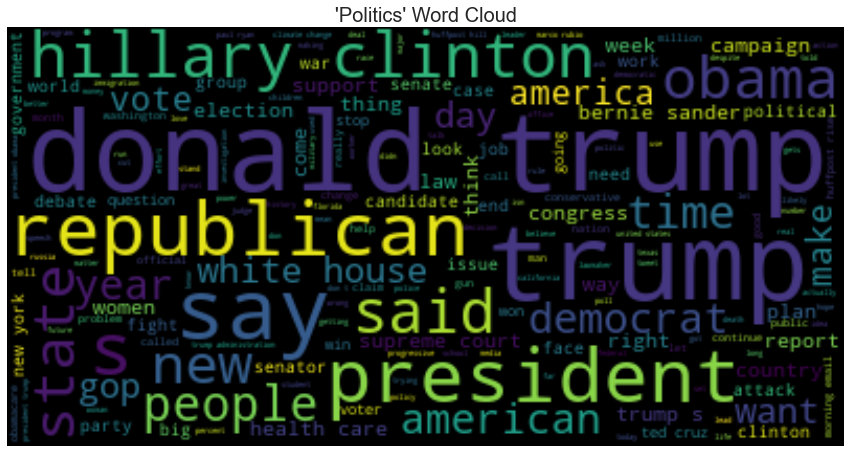

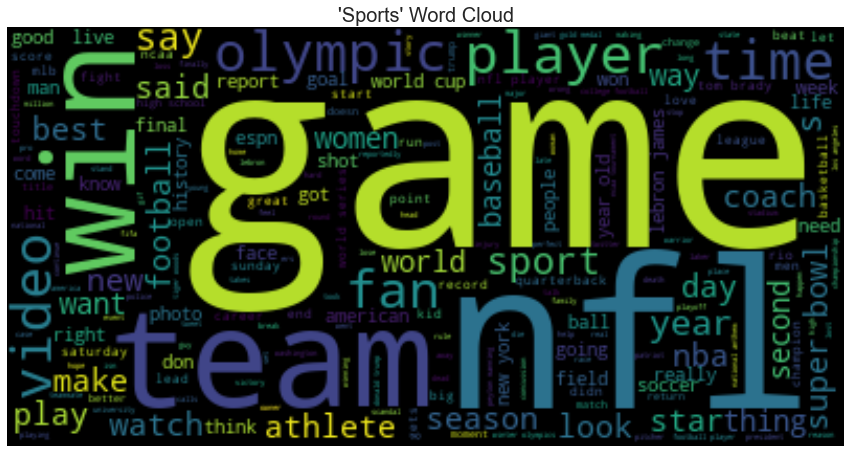

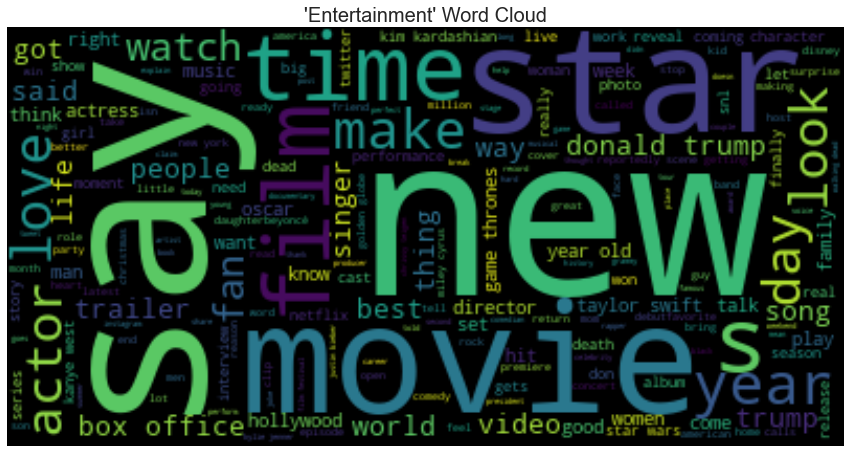

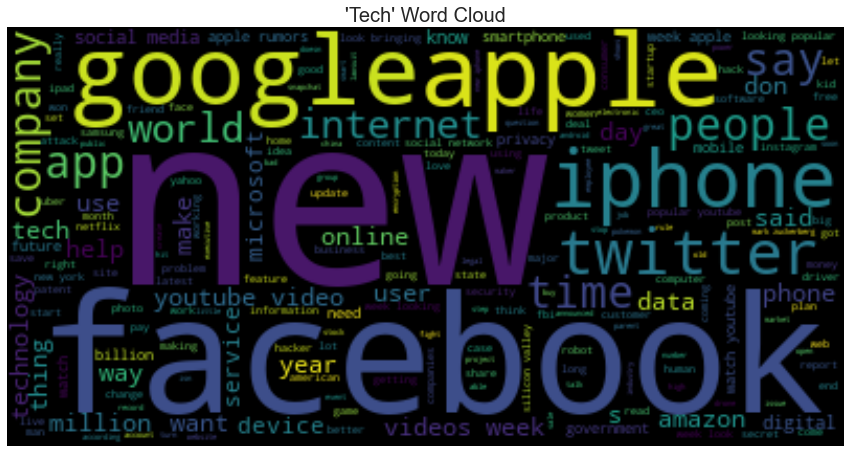

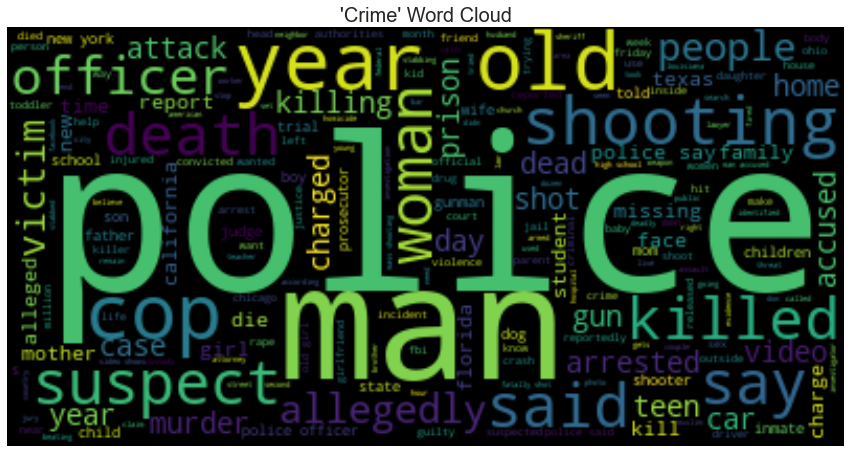

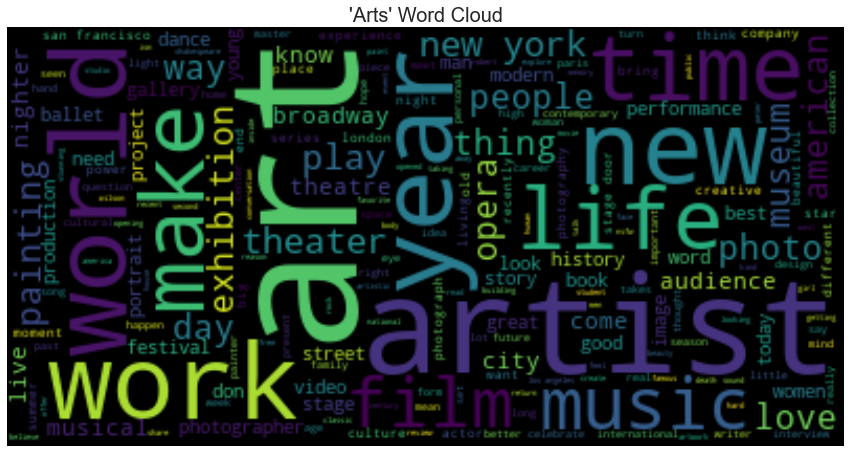

In [282]:
for cat in cats:
    text = ' '.join(eda_data[eda_data.category == cat].wordcloud_text.values)
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"'{cat.title()}' Word Cloud", fontsize=20)
    plt.axis('off')
    plt.show()
    print()

As one can see from this initial EDA, these demonstrate that there is potential for separation among these categories, as there are common words that are fairly unique towards each category. For example, "facebook" is obviously a very popular company associated with the tech industry so we find that it is one of the most common words in the technology category. Although we wouldn't necessarily expect to see this word associated with other categories, we can see that it does not come up in any of the other categories visualized here.

## Initial model - tfidf vectorizer and Naive Bayes classifier

In [283]:
X, y = data.combined, data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)

160682

In [284]:
vect = CountVectorizer()
X_train_counts = vect.fit_transform(X_train)
X_train_counts.shape

(160682, 78946)

In [285]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_train_tfidf.shape

(160682, 78946)

In [286]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [291]:
train_pred = clf.predict(X_train_tfidf)
np.mean(train_pred == y_train)  # accuracy on the training set

0.40662924285234187

In [292]:
X_test_counts = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)

test_pred = clf.predict(X_test_tfidf)
np.mean(test_pred == y_test)

0.379154116153444

In [ ]:
def test_sentence(sentence, vect, tfidf, clf):
    sent_counts = vect.transform([sentence])
    sent_tfidf = tfidf.transform(sent_counts)
    
    return list(category_dict.keys())[list(category_dict.values()).index(clf.predict(sent_tfidf))]
    

In [ ]:
sen = "Apple MacBook Pro 16-inch M1 Max review: New silicon meets retro ports. It's the best of the old and new in this long-awaited, professional-grade Apple silicon MacBook."

test_sentence(sen, vect, tfidf, clf)


'ENTERTAINMENT'

## RandomizedSearch CV with other algorithms.

In [223]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass
    def predict(self): pass

In [224]:
pipe = Pipeline([('count_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', DummyEstimator())])

In [225]:
search_space = [{'clf': [DecisionTreeClassifier()]},
               
                {'clf': [MultinomialNB()]},
                
                {'clf': [LogisticRegression()]}]
                
                

In [226]:
clf_search = RandomizedSearchCV(estimator=pipe, 
                                param_distributions=search_space,
                                n_iter=3,
                                cv=5,
                                n_jobs=-1,
                                verbose=1)

best_model = clf_search.fit(X_train, y_train)

best_model.best_estimator_.get_params()['clf']

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/kylebrooks/opt/anaconda3/envs/550-final-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kylebrooks/opt/anaconda3/envs/550-final-project/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

LogisticRegression()

In [228]:
best_model.predict(X_test)

array([ 9, 13, 34, ...,  1, 12,  4])

In [295]:
# Train accuracy
train_pred = best_model.predict(X_train)
np.mean(train_pred == y_train)

0.6760869294631633

In [234]:
# Test accuracy
y_pred = best_model.predict(X_test)
np.mean(y_pred == y_test)

0.6006074033506759

In [238]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,341,20,0,1,127,19,20,1,2,4,...,20,14,4,1,2,2,1,1,0,0
1,16,2453,1,8,181,10,44,32,64,26,...,62,39,6,35,14,4,8,0,0,0
2,10,18,72,6,129,3,4,5,0,2,...,6,5,0,2,0,0,1,0,0,0
3,0,19,2,173,108,2,15,21,2,9,...,120,44,3,2,0,0,11,3,0,0
4,47,96,14,29,5553,6,53,31,36,46,...,91,34,5,6,1,6,5,11,4,1
5,36,75,1,0,62,152,2,1,19,3,...,13,13,7,7,1,0,18,1,0,0
6,39,184,0,9,142,0,310,8,8,12,...,29,13,2,31,2,2,4,0,0,0
7,5,87,1,6,112,4,5,218,5,8,...,113,43,2,18,5,7,1,1,0,0
8,1,222,1,1,143,22,6,4,447,5,...,36,25,7,13,1,5,15,0,1,0
9,12,103,0,8,121,3,5,10,7,835,...,47,29,0,13,4,9,2,2,0,0


## Bags of words

In [86]:
data['combined'] = data.headline + '. ' + data.short_description 

In [88]:
# Assign fixed integer id to each word occurring in the document of the training set
count_vect = CountVectorizer()
test = count_vect.fit_transform(data.combined)

In [89]:
test

<200840x86670 sparse matrix of type '<class 'numpy.int64'>'
	with 4974671 stored elements in Compressed Sparse Row format>

# Scratch work

In [85]:
analyzer = SentimentIntensityAnalyzer()

analyzer.polarity_scores(data.combined[0])['compound']

-0.8047

In [73]:
def determine_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

In [75]:
# Combine the headline with the short description of the article --> likely will improve performance
data['combined'] = data.headline + '. ' + data.short_description 

analyzer = SentimentIntensityAnalyzer()

data['sentiment_score'] = [analyzer.polarity_scores(sentence)['compound'] for sentence in data.combined]
data['sentiment'] = data.sentiment_score.apply(determine_sentiment)

In [77]:
data[['combined', 'sentiment_score', 'sentiment']]

,combined,sentiment_score,sentiment
0,There Were 2 Mass Shootings In Texas Last Week...,-0.8047,negative
1,Will Smith Joins Diplo And Nicky Jam For The 2...,0.0000,neutral
2,Hugh Grant Marries For The First Time At Age 5...,0.3612,positive
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0.3412,positive
4,Julianna Margulies Uses Donald Trump Poop Bags...,0.0000,neutral
...,...,...,...
200848,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,0.5106,positive
200849,Maria Sharapova Stunned By Victoria Azarenka I...,0.2732,positive
200850,"Giants Over Patriots, Jets Over Colts Among M...",0.7635,positive
200851,Aldon Smith Arrested: 49ers Linebacker Busted ...,-0.4767,negative


In [82]:
def preprocessing(text):
    stop_words = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
    
    text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    
    tokens = [tok for tok in tokens if len(tok) > 2]  # remove short words that don't add much in the way of meaning
    tokens = [tok for tok in tokens if tok not in stop_words]
    
    p_stemmer = PorterStemmer()
    
    return [p_stemmer.stem(word) for word in tokens]
    

In [83]:
data['tokenized'] = data['combined'].apply(preprocessing)